# Assignment 1

Contents:

- [x] Setup
- [x] Data
    - [x] Preparing the SVHN dataset
    - [x] Visualization of images
- [x] Training and evaluation of an MLP Classifier
    - [x] Building the MLP model
    - [x] Training and evaluation
    - [x] Visualization of predictions
    - [ ] Visualization of performance
        - [x] Loss plots
        - [x] Classification accuracy plots
        - [ ] Confusion matrix
    - [ ] Visualization of statistics of the gradients for some parameters during training
- [ ] Hyperparameter optimization
    - [ ] Use *Optuna* to optimize (at least) two hyper-parameters (e.g, number of layers or hidden dimension)
    - [ ] Show some nice optimization plots :)
    - [ ] Discuss: What parameters seem more important? What values are reasonable?
- [ ] **Extra Point**
    - [ ] Train and evaluate a shallow [MLP-Mixer](https://openreview.net/pdf?id=EI2KOXKdnP) model
    - [ ] Compare it with the best MLP model from before. Does it work better? Why or why not?

## Setup

### Modules

In [116]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sbn
import sklearn.metrics as skl_metrics
import torch
import torchvision as tv
from tqdm import tqdm

### Paths

In [2]:
PATH_CWD = "."
DIR_DATA = "data"
DIR_DATASET = "svhn"
DIR_EXPERIMENTS = "experiments"
NAME_EXPERIMENT = "mlp_svhn"

path_cwd = Path(PATH_CWD)
path_dir_dataset = path_cwd / DIR_DATA / DIR_DATASET
path_dir_experiment = path_cwd / DIR_EXPERIMENTS / NAME_EXPERIMENT

### Config

In [3]:
BATCHSIZE = 1024
SHUFFLE_TRAIN = True
SHUFFLE_TEST = False
NUM_WORKERS_DATALOADING = 4
NUM_EPOCHS = 10
LR = 1e-3
DIMS_HIDDEN = [256]
LAYER_NORM = torch.nn.BatchNorm1d
LAYER_ACTIVATION = torch.nn.ReLU
USE_BIAS = True
PROB_DROPOUT = 0.2
# Includes softmax
CRITERION = torch.nn.CrossEntropyLoss
OPTIMIZER = torch.optim.Adam
FREQUENCY_CHECKPOINTS = 40
METRICS = ["accuracy"]

## Data

### Preparing the SVHN dataset

In [4]:
dataset_train = tv.datasets.SVHN(root=path_dir_dataset, split="train", transform=tv.transforms.ToTensor(), download=True)
dataset_test = tv.datasets.SVHN(root=path_dir_dataset, split="test", transform=tv.transforms.ToTensor(), download=True)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCHSIZE, shuffle=SHUFFLE_TRAIN, num_workers=NUM_WORKERS_DATALOADING)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCHSIZE, shuffle=SHUFFLE_TEST, num_workers=NUM_WORKERS_DATALOADING)

print("Training dataset")
print(f"    {"Length":<10}: {len(dataset_train)}")
print(f"    {"Batches":<10}: {len(dataloader_train)}")
print("Test dataset")
print(f"    {"Length":<10}: {len(dataset_test)}")
print(f"    {"Batches":<10}: {len(dataloader_test)}")

Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training dataset
    Length    : 73257
    Batches   : 72
Test dataset
    Length    : 26032
    Batches   : 26


### Visualization of images

In [5]:
def sample(dataset, indices):
    """Sample indexed items from dataset by converting list of tuples of k elements into k separate lists."""
    lists = map(list, zip(*[dataset[i] for i in indices]))
    return lists

In [6]:
num_samples = 17
indices = np.random.randint(low=0, high=len(dataset_train), size=num_samples)
list_images, list_labels = sample(dataset_train, indices)
images = torch.stack(list_images)
labels = torch.as_tensor(list_labels)

print(f"Shape of dataset sample: {images.shape}")
print(f"Labels: {labels}")

Shape of dataset sample: torch.Size([17, 3, 32, 32])
Labels: tensor([4, 8, 3, 2, 6, 2, 8, 8, 9, 1, 7, 7, 4, 4, 1, 5, 7])


In [7]:
def visualize_images(images, labels=None, indices=None):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_image(i):
        ax = plt.gca()

        if labels is not None or indices is not None:
            title = ""
            if indices is not None:
                title += rf"#${indices[i]}$"
            if indices is not None and labels is not None:
                title += " | "
            if labels is not None:
                title += rf"label: {labels[i]}"
            ax.set_title(title, fontsize=9)
        ax.set_axis_off()

        ax.imshow(images[i])

    # Assume same shape for all images
    aspect_images = images[0].shape[1] / images[0].shape[0]
    figsize = fig.get_size_inches()
    aspect_figure = figsize[1] / figsize[0]

    num_subplots = len(images)
    num_rows = max(int(np.sqrt(num_subplots) * aspect_figure / aspect_images), 1)
    num_cols = np.ceil(num_subplots / num_rows).astype(int)
    for i in range(num_subplots):
        fig.add_subplot(num_rows, num_cols, i + 1)
        subplot_image(i)

    plt.tight_layout()
    plt.show()

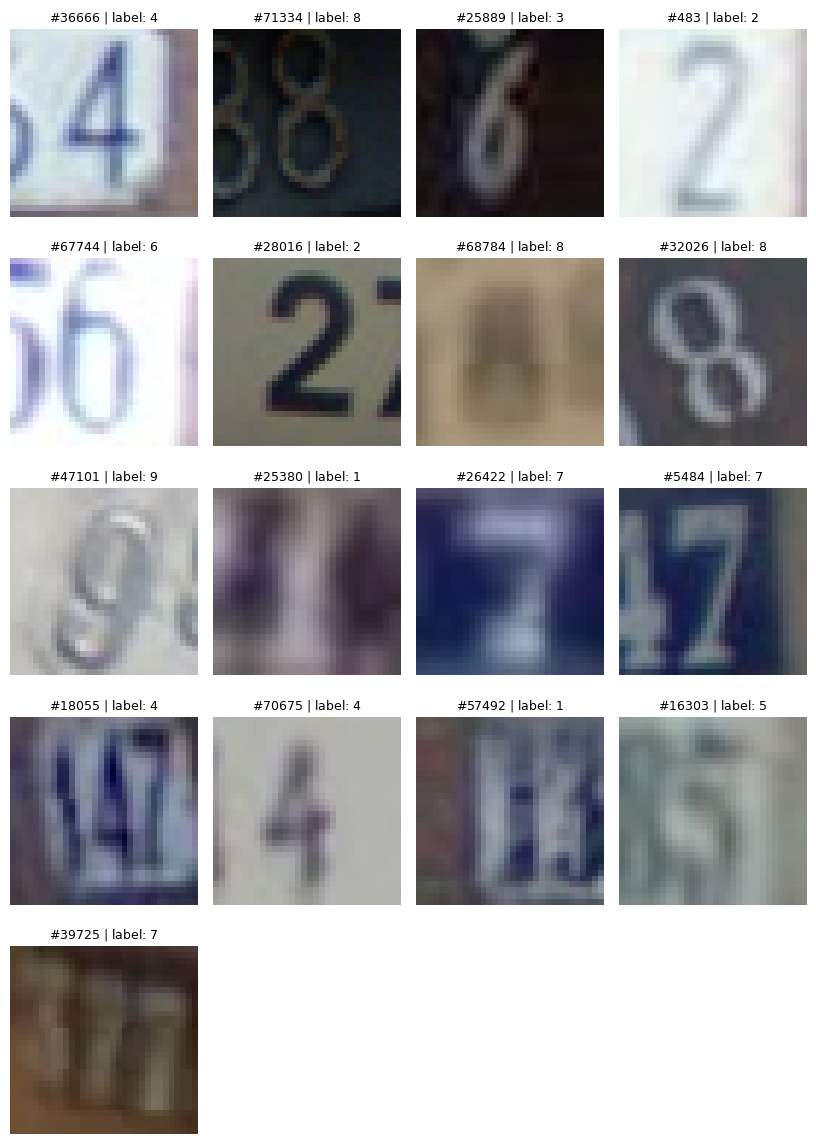

In [8]:
visualize_images(images.permute(0, 2, 3, 1), labels=labels, indices=indices)

## Training and evaluation of an MLP Classifier

### Building the MLP model

In [9]:
class MLP(torch.nn.Module):
    def __init__(
        self,
        dim_input,
        dims_hidden,
        dim_output,
        layer_norm=None,
        layer_activation=torch.nn.ReLU,
        inplace=None,
        bias=True,
        dropout=None,
    ):
        super().__init__()

        kwargs_inplace = {} if inplace is None else {"inplace": inplace}
        dims = [dim_input] + dims_hidden + [dim_output]

        list_layers = []
        for dim_in, dim_out in zip(dims[:-2], dims[1:-1]):
            list_layers.append(torch.nn.Linear(dim_in, dim_out, bias=bias))
            if layer_norm is not None:
                list_layers.append(layer_norm(dim_out))
            list_layers.append(layer_activation(**kwargs_inplace))
            if dropout is not None:
                list_layers.append(torch.nn.Dropout(dropout, **kwargs_inplace))
        list_layers.append(torch.nn.Linear(dims[-2], dims[-1], bias=bias))

        self.layers = torch.nn.Sequential(*list_layers)

    def forward(self, x):
        prediction = self.layers(x)
        return prediction

In [10]:
dim_input = np.prod(np.asarray(dataset_train.data.shape[1:]))
labelset = np.unique(dataset_test.labels)

model = MLP(
    dim_input=dim_input,
    dims_hidden=DIMS_HIDDEN,
    dim_output=labelset.size,
    layer_norm=LAYER_NORM,
    layer_activation=LAYER_ACTIVATION,
    bias=USE_BIAS,
    dropout=PROB_DROPOUT,
)

print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [11]:
def count_model_params(model):
    """Counting the number of learnable parameters in a torch.nn.Module"""
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [12]:
num_params = count_model_params(model)

print(f"Number of parameters: {num_params}")

Number of parameters: 789770


### Training and evaluation

In [13]:
def save_checkpoint(path_dir_experiment, epoch, model, optimizer, name=None):
    path_dir_checkpoints = path_dir_experiment / "checkpoints"
    path_dir_checkpoints.mkdir(parents=True, exist_ok=True)

    filename = f"{name}.pth" if name is not None else f"epoch_{epoch}.pth"
    path_checkpoint = path_dir_checkpoints / filename
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        path_checkpoint,
    )

In [14]:
def load_checkpoint(path, class_model):
    model = class_model()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = CRITERION()
    optimizer = OPTIMIZER(model.parameters(), lr=LR)

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]

    return epoch, model, criterion, optimizer

In [15]:
def accuracy(output, targets):
    predictions = torch.argmax(output, dim=-1)
    num_correct = len(torch.where(predictions == targets)[0])
    accuracy = num_correct / len(targets)
    return accuracy

In [16]:
def train_epoch(epoch, model, device, dataloader, criterion, optimizer):
    progress_bar = tqdm(dataloader_train, total=len(dataloader))
    losses = []
    metricss = []
    for i, (features, targets) in enumerate(progress_bar):
        features = features.to(device)
        targets = targets.to(device)

        features_flat = features.flatten(start_dim=1)
        output = model(features_flat)

        loss = criterion(output, targets)
        losses += [loss.item()]

        metrics = dict.fromkeys(METRICS, 0.0)
        for metric in METRICS:
            metrics[metric] = eval(metric)(output, targets)
        metricss += [metrics]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0 or i == len(dataloader) - 1:
            progress_bar.set_description(f"Training: Epoch {epoch:03d} | Batch {i:04d} | Loss {loss.item():.5f}")

    return losses, metricss

In [17]:
@torch.no_grad()
def evaluate_epoch(epoch, model, device, dataloader, criterion):
    progress_bar = tqdm(dataloader, total=len(dataloader))
    loss_unnormalized = 0.0
    metrics_unnormalized = dict.fromkeys(METRICS, 0.0)
    for i, (features, targets) in enumerate(progress_bar):
        features = features.to(device)
        targets = targets.to(device)

        features_flat = features.flatten(start_dim=1)
        output = model(features_flat)

        loss = criterion(output, targets)
        loss_unnormalized += loss.item() * len(targets)

        for metric in METRICS:
            metrics_unnormalized[metric] += eval(metric)(output, targets) * len(targets)

        if i % 10 == 0 or i == len(dataloader) - 1:
            progress_bar.set_description(f"Evaluation: Epoch {epoch:03d} | Batch {i:04d} | Loss {loss.item():.5f}")

    loss = loss_unnormalized / len(dataloader_test.dataset)
    metrics = {}
    for key, value in metrics_unnormalized.items():
        metrics[key] = value / len(dataloader_test.dataset)
    return loss, metrics

In [18]:
def training_loop(model, device, dataloader_train, dataloader_test, path_dir_experiment):
    criterion = CRITERION()
    optimizer = OPTIMIZER(model.parameters(), lr=LR)

    losses_train = []
    losses_test = []
    metricss_train = []
    metricss_test = []

    model.eval()
    loss_test_epoch, metrics_test_epoch = evaluate_epoch(0, model, device, dataloader_test, criterion)
    losses_test += [loss_test_epoch]
    metricss_test += [metrics_test_epoch]

    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        losses_train_epoch, metricss_train_epoch = train_epoch(epoch, model, device, dataloader_train, criterion, optimizer)
        losses_train += losses_train_epoch
        metricss_train += metricss_train_epoch

        save_checkpoint(path_dir_experiment, epoch, model, optimizer, name="latest")
        if epoch % FREQUENCY_CHECKPOINTS == 1 and epoch != 1:
            print("Saving model checkpoint")
            save_checkpoint(path_dir_experiment, epoch, model, optimizer)

        model.eval()
        loss_test_epoch, metrics_test_epoch = evaluate_epoch(epoch, model, device, dataloader_test, criterion)
        losses_test += [loss_test_epoch]
        metricss_test += [metrics_test_epoch]

    print("Finished training")
    save_checkpoint(path_dir_experiment, epoch, model, optimizer, name="final")
    return losses_train, losses_test, metricss_train, metricss_test, model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

losses_train, losses_test, metricss_train, metricss_test, model_trained = training_loop(
    model,
    device,
    dataloader_train,
    dataloader_test,
    path_dir_experiment,
)

Evaluation: Epoch 000 | Batch 0025 | Loss 2.33909: 100%|██████████| 26/26 [00:00<00:00, 29.36it/s]
Training: Epoch 001 | Batch 0071 | Loss 1.49253: 100%|██████████| 72/72 [00:02<00:00, 33.73it/s]
Evaluation: Epoch 001 | Batch 0025 | Loss 1.47994: 100%|██████████| 26/26 [00:00<00:00, 28.81it/s]
Training: Epoch 002 | Batch 0071 | Loss 1.07239: 100%|██████████| 72/72 [00:02<00:00, 31.39it/s]
Evaluation: Epoch 002 | Batch 0025 | Loss 1.17795: 100%|██████████| 26/26 [00:00<00:00, 29.89it/s]
Training: Epoch 003 | Batch 0071 | Loss 0.90771: 100%|██████████| 72/72 [00:02<00:00, 33.72it/s]
Evaluation: Epoch 003 | Batch 0025 | Loss 1.09470: 100%|██████████| 26/26 [00:00<00:00, 28.88it/s]
Training: Epoch 004 | Batch 0071 | Loss 0.87082: 100%|██████████| 72/72 [00:02<00:00, 35.67it/s]
Evaluation: Epoch 004 | Batch 0025 | Loss 1.01243: 100%|██████████| 26/26 [00:00<00:00, 27.95it/s]
Training: Epoch 005 | Batch 0071 | Loss 0.77443: 100%|██████████| 72/72 [00:02<00:00, 33.69it/s]
Evaluation: Epoch 00

Finished training


### Visualization of predictions

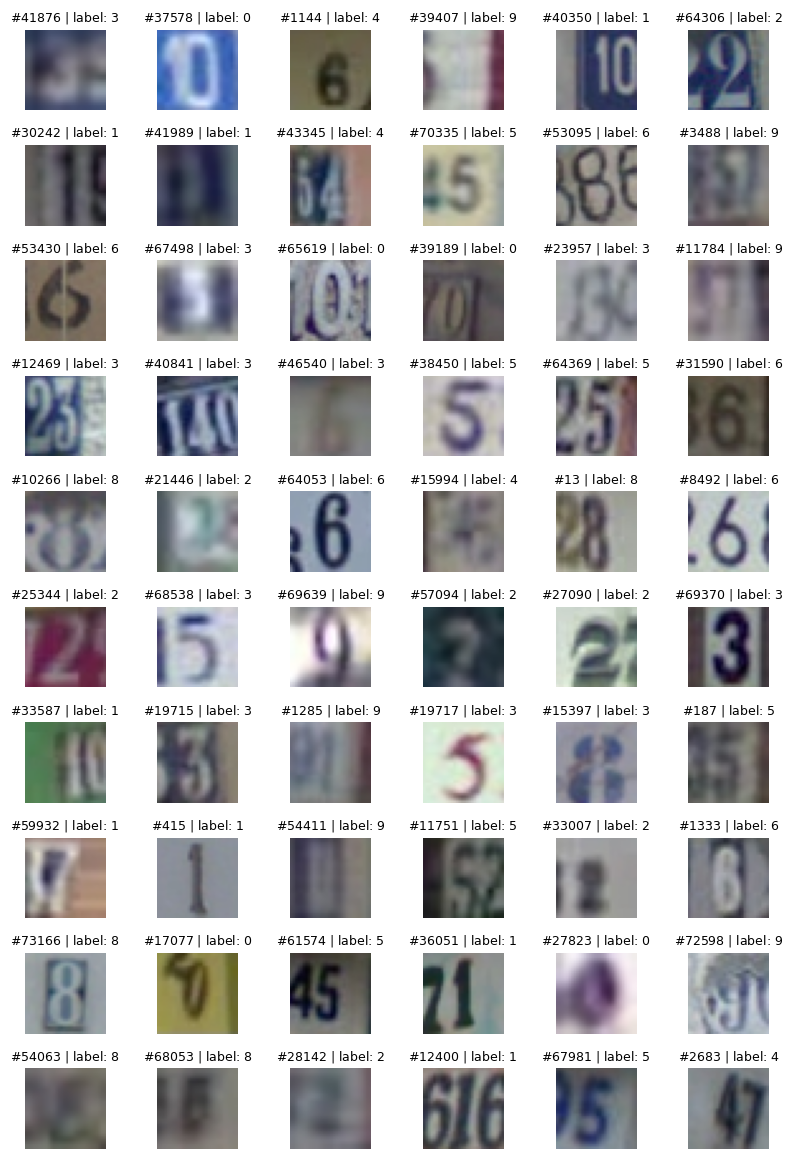

In [20]:
num_samples = 60
indices = np.random.randint(low=0, high=len(dataset_train), size=num_samples)
list_images, _ = sample(dataset_train, indices)
images = torch.stack(list_images)

images = images.to(device)
images_flat = images.flatten(start_dim=1)
output = model_trained(images_flat)
predictions = torch.argmax(output, dim=-1)

visualize_images(images.permute(0, 2, 3, 1).cpu(), labels=predictions.cpu(), indices=indices)

> As one can see, the training was somewhat successful. Many labels are correctly identified.

### Visualization of performance

#### Loss plots

In [21]:
def iterations2epochs(iterations, batchsize, num_samples):
    """Convert array of total batch iterations to epoch scale. Also works if not the entire dataset is traversed during training."""
    num_batches = np.ceil(num_samples / batchsize).astype(int)
    samples = (iterations // num_batches) * num_samples + (iterations % num_batches) * batchsize
    batchsize_last = ((num_samples - 1) % batchsize) + 1
    samples[num_batches - 1 :: num_batches] += batchsize_last - batchsize
    epochs = samples / num_samples
    return epochs

In [28]:
def mean_per_epoch(values, batchsize, num_samples):
    num_batches = np.ceil(num_samples / batchsize).astype(int)
    batchsize_last = ((num_samples - 1) % batchsize) + 1
    batchsizes = np.asarray([batchsize] * (num_batches - 1) + [batchsize_last])
    values_epochs = np.asarray(values).reshape(-1, num_batches)
    values_epochs = np.sum(values_epochs * batchsizes, axis=1) / num_samples
    return values_epochs

In [90]:
def smooth(f, k=5):
    """Smoothing a function using a low-pass filter (mean) of size K"""
    kernel = np.ones(k) / k
    # Account for boundaries
    f = np.concatenate([f[: int(k // 2)], f, f[int(-k // 2) :]])
    smooth_f = np.convolve(f, kernel, mode="same")
    # Remove boundary-fixes
    smooth_f = smooth_f[k // 2 : -k // 2]
    return smooth_f

In [101]:
def plot_loss(iterations_train, losses_train, losses_test, num_samples_train):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_loss(use_logscale=False):
        ax = plt.gca()

        ax.set_title(f"Training progress ({"logscale" if use_logscale else "linearscale"})", fontsize=9)
        ax.set_xlabel("Epoch", fontsize=9)
        ax.set_ylabel("Cross-entropy loss", fontsize=9)
        ax.tick_params(axis="both", which="major", labelsize=9)
        ax.tick_params(axis="both", which="minor", labelsize=8)
        ax.grid(alpha=0.4)
        if use_logscale:
            ax.set_yscale("log")

        epochs_iterations_train = iterations2epochs(iterations_train, BATCHSIZE, num_samples_train)
        losses_train_smoothed = smooth(losses_train, k=int(num_samples_train / (BATCHSIZE * 2)))

        ax.plot(epochs_iterations_train, losses_train, alpha=0.8, label="Loss (training)")
        ax.plot(epochs_iterations_train, losses_train_smoothed)
        ax.plot(losses_test, label="Loss (evaluation)")

        ax.legend(fontsize=9)

    fig.add_subplot(3, 1, 1)
    subplot_loss()

    fig.add_subplot(3, 1, 2)
    subplot_loss(use_logscale=True)

    plt.tight_layout()
    plt.show()

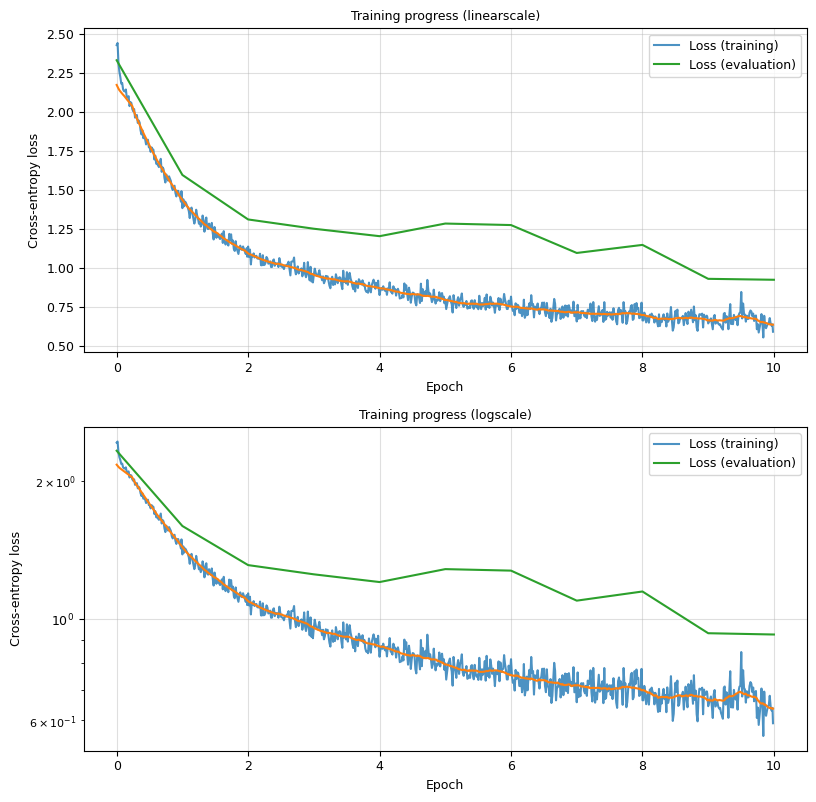

In [102]:
iterations_train = np.arange(len(losses_train), dtype=float)

plot_loss(
    iterations_train,
    losses_train,
    losses_test,
    num_samples_train=len(dataset_train),
)

> As one can see, the predicted labels are.

#### Classification accuracy plots

In [99]:
def plot_metrics(iterations_train, metricss_train, metricss_test, num_samples_train):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_loss(use_logscale=False):
        ax = plt.gca()

        ax.set_title(f"Training progress ({"logscale" if use_logscale else "linearscale"})", fontsize=9)
        ax.set_xlabel("Epoch", fontsize=9)
        ax.set_ylabel("Accuracy", fontsize=9)
        ax.tick_params(axis="both", which="major", labelsize=9)
        ax.tick_params(axis="both", which="minor", labelsize=8)
        ax.grid(alpha=0.4)
        if use_logscale:
            ax.set_yscale("log")

        epochs = np.arange(len(losses_test))
        epochs_iterations_train = iterations2epochs(iterations_train, BATCHSIZE, num_samples_train)

        for metric in metricss_train[0].keys():
            values_metric_train = [metrics[metric] for metrics in metricss_train]
            values_metric_train_smoothed = smooth(values_metric_train, k=int(num_samples_train / (BATCHSIZE * 2)))

            ax.plot(epochs_iterations_train, values_metric_train, alpha=0.8, label=f"{metric.capitalize()} (training)")
            ax.plot(epochs_iterations_train, values_metric_train_smoothed)

        for metric in metricss_test[0].keys():
            values_metric_test = [metrics[metric] for metrics in metricss_test]
            ax.plot(epochs, values_metric_test, label=f"{metric.capitalize()} (evaluation)")

        ax.legend(fontsize=9)

    fig.add_subplot(3, 1, 1)
    subplot_loss()

    fig.add_subplot(3, 1, 2)
    subplot_loss(use_logscale=True)

    plt.tight_layout()
    plt.show()

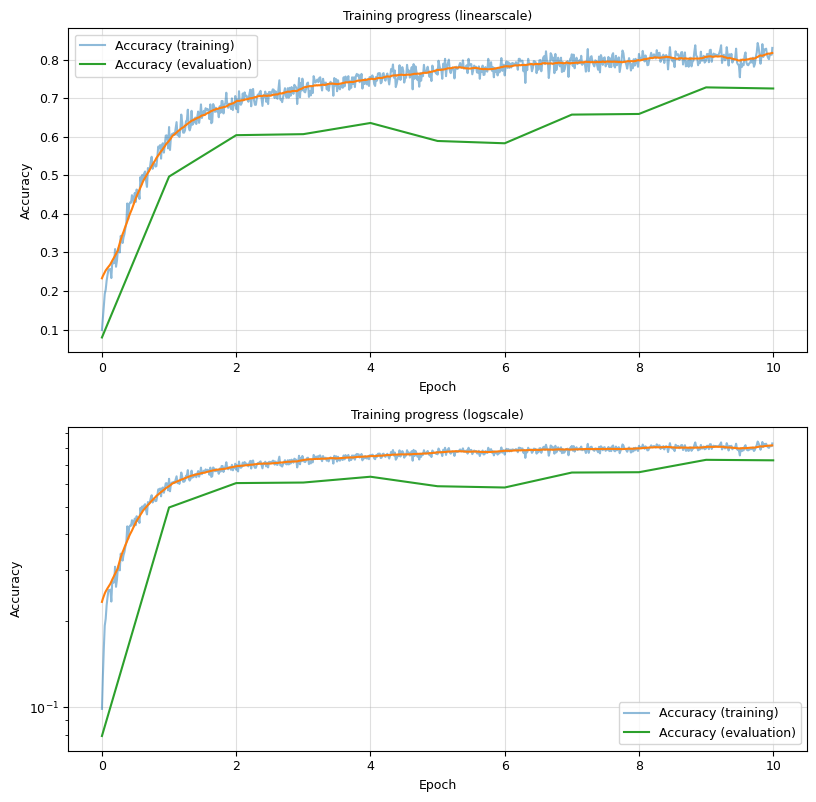

In [100]:
plot_metrics(
    iterations_train,
    metricss_train,
    metricss_test,
    num_samples_train=len(dataset_train),
)

> As one can see, the predicted labels are.

#### Confusion matrix

In [145]:
def visualize_confusion(confusion, labelset):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_confusion():
        ax = plt.gca()

        confusion_normalized = confusion / np.sum(confusion, axis=1)
        df_confusion = pd.DataFrame(confusion_normalized, index=labelset, columns=labelset)

        sbn.heatmap(df_confusion, annot=True)

        ax.set_title("Confusion matrix", fontsize=9)
        ax.set_xlabel("Target", fontsize=9)
        ax.set_ylabel("Prediction", fontsize=9)
        ax.tick_params(bottom=False, left=False)

    fig.add_subplot(3, 1, 1)
    subplot_confusion()

    plt.tight_layout()
    plt.show()

In [117]:
def run_inference(model, device, dataloader):
    progress_bar = tqdm(dataloader, total=len(dataloader))
    predictions = []
    targets = []
    for i, (features, target) in enumerate(progress_bar):
        features = features.to(device)
        target = target.to(device)

        features_flat = features.flatten(start_dim=1)
        output = model(features_flat)

        predictions += [torch.argmax(output, dim=-1).item()]
        targets += [target.item()]

        if i % 10 == 0 or i == len(dataloader) - 1:
            progress_bar.set_description(f"Inference: Features {i:04d}")

    return predictions, targets

In [112]:
dataloader_inference = torch.utils.data.DataLoader(dataset_test, shuffle=SHUFFLE_TEST, num_workers=NUM_WORKERS_DATALOADING)

predictions, targets = run_inference(model_trained, device, dataloader_inference)

Inference: Features 26031: 100%|██████████| 26032/26032 [00:24<00:00, 1045.05it/s]


NameError: name 'skl_metrics' is not defined

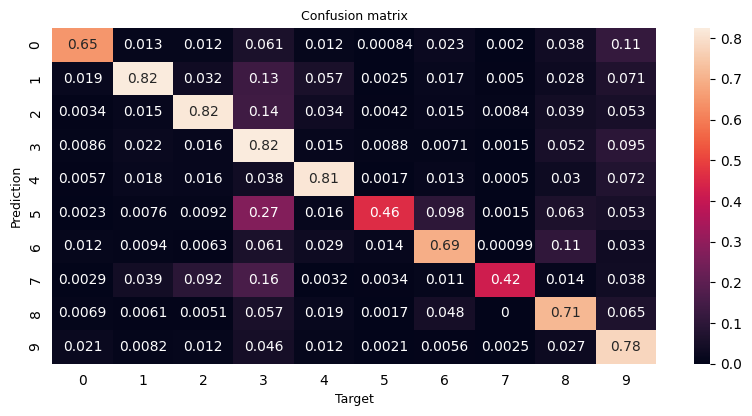

In [146]:
confusion = skl_metrics.confusion_matrix(targets, predictions)

visualize_confusion(confusion, labelset)

> As one can see, the predicted labels are mostly wrong.

### Visualization of statistics of the gradients for some parameters during training

In [ ]:
class GradientInspector:
    STATS = ["Min", "Max", "Mean", "MeanAbs", "Var", "Norm"]
    FUNCS = {
        "Min": torch.min,
        "Max": torch.max,
        "Mean": torch.mean,
        "MeanAbs": lambda x: x.abs().mean(),
        "Var": torch.var,
        "Norm": torch.norm,
    }

    def __init__(self, writer, layers, names, stats=None):
        """Module initializer"""
        stats = stats if stats is not None else GradientInspector.STATS
        for stat in stats:
            assert stat in GradientInspector.STATS, f"{stat = } not included in {self.STATS = }"
        assert isinstance(layers, list), f"Layers is not list, but {type(layers)}..."
        assert len(layers) == len(names), f"{len(layers) = } and {len(names) = } must be the same..."
        for layer in layers:
            assert isinstance(layer, torch.nn.Module), f"Layer is not nn.Module, but {type(layer)}..."
            assert hasattr(layer, "weight"), "Layer does not have attribute 'weight'"

        self.writer = writer
        self.layers = layers
        self.names = names
        self.stats = stats

        print("Initializing Gradient-Inspector:")
        print(f"  --> Tracking stats {stats} of gradients in the following layers")
        for name, layer in zip(names, layers):
            print(f"    --> {name}: {layer}")
        return

    def __call__(self, step):
        """Computing gradient stats and logging into Tensorboard"""
        for layer, name in zip(self.layers, self.names):
            grad = layer.weight.grad
            for stat in self.stats:
                func = self.FUNCS[stat]
                self.writer.add_scalar(f"Grad Stats {name}/{stat} Grad", func(grad).item(), step)
        return

> As one can see, the predicted labels are mostly wrong.

How do these change?

> 